In [2]:
import importlib.util
spec = importlib.util.spec_from_file_location("BoundaryLayerToolbox", "/Users/claudiopierard/VC/BoundaryLayerToolbox.py")
blt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(blt)

In [3]:
import matplotlib
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as spy
import scipy.io as sio
import scipy.optimize as optimization
import scipy.interpolate as interpolate
from netCDF4 import Dataset
import os
import pandas as pd
pd.set_option('html', False)
from IPython import display
from matplotlib import animation
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [4]:
xlat = np.loadtxt("/Users/claudiopierard/VC/datos/xlat_d02_interpolado.txt")
xlong = np.loadtxt("/Users/claudiopierard/VC/datos/xlong_d02_interpolado.txt")
hgt = np.loadtxt("/Users/claudiopierard/VC/datos/hgt_d02_interpolado.txt")

In [5]:
months = {1:'jan', 2:'feb', 3:'mar',4: 'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dic'}

In [6]:
path2datosVC = "/Volumes/BUFFALO_SOLDIER/datos_VC/"
path2estaciones = "../datos/loc_estaciones/air_quality_stn.xy"

In [7]:
estaciones = pd.read_table(path2estaciones, index_col=0, names=['long','lat', 'height'])

In [8]:
estaciones = estaciones.transpose().to_dict()

In [9]:
estaciones['CCA']

{'height': 2294.0, 'lat': 19.326110999999997, 'long': -99.176110999999992}

In [10]:
def E1or30(month):
    if month in ['jan', 'mar', 'may', 'jul', 'aug', 'oct', 'dic']:
        return '31'
    elif  month in ['apr', 'jun', 'sep', 'jul', 'nov']:
        return '30'
    elif month == 'feb':
        return '28'

In [11]:
VC = pd.DataFrame()
PBLH = pd.DataFrame()
U_mean = pd.DataFrame()

for i in range(1, 13):
    print('Procesando y concatenando:',path2datosVC+"%02d"%i+'/'+ months[i]+'_24.h5')
    file_h5 = h5py.File(path2datosVC+"%02d"%i+'/'+ months[i]+'_24.h5', 'r')
    vc_24 = np.array(file_h5.get('vc_24h'))
    pblh_24 = np.array(file_h5.get('pblh_24h'))
    u_mean_24 = np.array(file_h5.get('u_mean_24h'))
    
    month_vc = pd.DataFrame()
    month_pblh = pd.DataFrame()
    month_u_mean = pd.DataFrame()
    
    mm = months[i]
    date_i = '2015-' + "%02d"%i + '-01' + ' ' + '00:00:00'
    date_f_wrf = '2015-' + "%02d"%i + '-' + E1or30(mm) + ' ' + "23:50:00"
    print(mm)
    
    if mm == 'nov':
        BEG = pd.date_range('2015-11-01 00:00:00', '2015-11-05 23:00:00', freq='1D')
        ENDD = pd.date_range('2015-11-07 00:00:00', '2015-11-18 23:00:00', freq='1D')
        BEG = BEG.union(ENDD)
        ENDD = pd.date_range('2015-11-20 00:00:00', '2015-11-20 23:00:00', freq='1D')
        BEG = BEG.union(ENDD)
        ENDD = pd.date_range('2015-11-22 00:00:00', '2015-11-30 23:00:00', freq='1D')
        month_t_range = BEG.union(ENDD)

    elif mm == 'jun':
        BEG = pd.date_range('2015-06-01 00:00:00', '2015-06-11 23:00:00', freq='1D')
        ENDD = pd.date_range('2015-06-13 00:00:00', '2015-06-30 23:00:00', freq='1D')
        month_t_range = BEG.union(ENDD)

    elif mm == 'oct':
        BEG = pd.date_range('2015-10-01 00:00:00', '2015-10-03 23:00:00', freq='1D')
        ENDD = pd.date_range('2015-10-05 00:00:00', '2015-10-31 23:00:00', freq='1D')
        month_t_range = BEG.union(ENDD)

    elif mm == 'jan':
        #print('True')
        month_t_range = pd.date_range('2015-01-15 00:00:00', '2015-01-31 23:00:00', freq='1D') ##Falta esta fechas

    elif mm == 'apr':
        month_t_range = pd.date_range('2015-04-02 00:00:00', '2015-04-30 23:00:00', freq='1D') ##Falta esta fechas

    else:
        month_t_range = pd.date_range(date_i, date_f_wrf, freq='1D')
    
    print(month_t_range.shape)
    for j in range(0,24):
        
        A = pd.DataFrame(vc_24[:,j,40,24], index=month_t_range, columns=[j])
        #print('oc')
        B = pd.DataFrame(pblh_24[:,j,40,24], index=month_t_range, columns=[j])
        C = pd.DataFrame(u_mean_24[:,j,40,24], index=month_t_range, columns=[j])
        
        month_vc = pd.concat([month_vc,A], axis=1)
        month_pblh = pd.concat([month_pblh,B], axis=1)
        month_u_mean = pd.concat([month_u_mean,C], axis=1)
        
    VC = pd.concat([VC,month_vc], axis=0)
    PBLH = pd.concat([PBLH,month_pblh], axis=0)
    U_mean = pd.concat([U_mean, month_u_mean], axis=0)

Procesando y concatenando: /Volumes/BUFFALO_SOLDIER/datos_VC/01/jan_24.h5


OSError: Unable to open file (Unable to open file: name = '/volumes/buffalo_soldier/datos_vc/01/jan_24.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [12]:
VC.to_csv("VC.csv")
U_mean.to_csv("U_mean.csv", float_format='%.3f')
PBLH.to_csv("PBLH.csv", float_format='%.1f')

In [12]:
VC.shape

(345, 24)

In [13]:
VC_mean = np.zeros(24)
VC_std = np.zeros(24)
PBLH_mean = np.zeros(24)
PBLH_std = np.zeros(24)
U_mean_mean = np.zeros(24)
U_mean_std = np.zeros(24)

for i in range(0, 24):

    VC_mean[i] = VC[i].mean()
    VC_std[i] = VC[i].std()
    PBLH_mean[i] = PBLH[i].mean()
    PBLH_std[i] = PBLH[i].std()
    U_mean_mean[i] = U_mean[i].mean()
    U_mean_std[i] = U_mean[i].std()
    
VC_df = pd.DataFrame({'vc_mean': VC_mean, 'vc_std': VC_std})
PBLH_df = pd.DataFrame({'pblh_mean': PBLH_mean, 'pblh_std': PBLH_std})
U_mean_df = pd.DataFrame({'u_mean': U_mean_mean, 'u_std': U_mean_std})

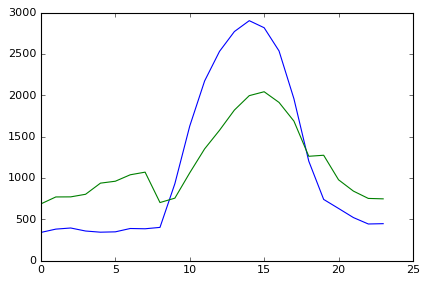

In [14]:
plt.plot(VC_df['vc_mean'])
plt.plot(VC_df['vc_std'])

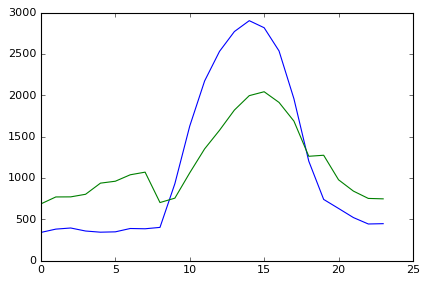

In [15]:
plt.plot(VC_mean)
plt.plot(VC_std)

In [16]:
VC.std()

0      685.776679
1      769.447698
2      770.381737
3      801.821328
4      936.479295
5      959.635414
6     1037.504711
7     1069.419080
8      701.731487
9      754.874546
10    1061.236996
11    1351.035444
12    1575.740661
13    1820.309834
14    1994.895906
15    2042.131481
16    1912.889434
17    1687.113997
18    1261.398791
19    1273.850865
20     977.024801
21     840.088404
22     751.595097
23     746.454124
dtype: float64

In [17]:
VC_std

array([  685.7766788 ,   769.44769801,   770.38173738,   801.82132834,
         936.47929496,   959.63541362,  1037.50471145,  1069.41907995,
         701.73148657,   754.87454575,  1061.23699591,  1351.03544424,
        1575.7406608 ,  1820.30983407,  1994.89590641,  2042.13148146,
        1912.88943405,  1687.11399674,  1261.39879105,  1273.85086513,
         977.02480109,   840.08840446,   751.5950967 ,   746.45412438])

In [18]:
VC.mean(axis=0)

0      340.217391
1      380.307246
2      393.860870
3      357.298551
4      343.124638
5      347.362319
6      387.695652
7      384.472464
8      401.220290
9      929.852174
10    1626.855072
11    2172.707246
12    2530.144928
13    2770.153623
14    2901.759420
15    2816.414493
16    2535.817391
17    1958.066667
18    1202.252174
19     739.643478
20     630.437681
21     519.913043
22     442.356522
23     446.191304
dtype: float64

In [1]:
VC.max(axis=1)

NameError: name 'VC' is not defined

In [20]:
np.array([VC.values.mean(), VC.values.std()])

array([ 1148.25519324,  1557.88401047])

# CCA

In [21]:
cca_vc = pd.read_csv("../datos/promedios_estaciones/CCA/VC_anual.csv", index_col= 0)

In [22]:
cca_vc_prom_hora = pd.read_csv("../datos/promedios_estaciones/CCA/VC_anual_promedio.csv", index_col= 0)

In [23]:
vc_mean_anual, vc_std_anual = np.loadtxt("../datos/promedios_estaciones/CCA/VC_promedio_std.dat")

In [24]:
cca_vc.index = pd.to_datetime(cca_vc.index)

In [25]:
cca_jan_vc_mean = cca_vc['2015-01-01':'2015-01-31'].mean()

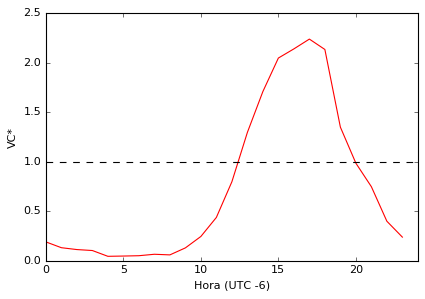

In [26]:
plt.plot(cca_jan_vc_mean/vc_mean_anual, 'r')
plt.plot([0,24], [1,1], '--k')
#plt.ylim(-1,1)
plt.xlim(0,24)
plt.xlabel('Hora (UTC -6)')
plt.ylabel('VC*')

In [27]:
cca_jan_vc_mean = cca_vc['2015-01-01':'2015-01-31'].mean().values

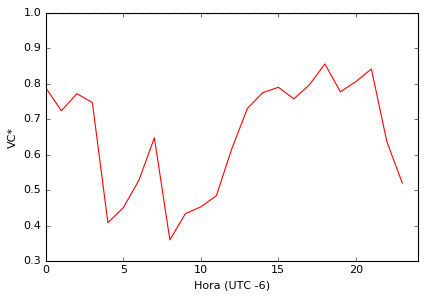

In [28]:
plt.plot(cca_jan_vc_mean/cca_vc_prom_hora.vc_mean.values, 'r')
plt.plot([0,24], [1,1], '--k')
#plt.ylim(-1,1)
plt.xlim(0,24)
plt.xlabel('Hora (UTC -6)')
plt.ylabel('VC*')

In [29]:
c = plt.cm.jet(1. * 1 / (12 - 1))

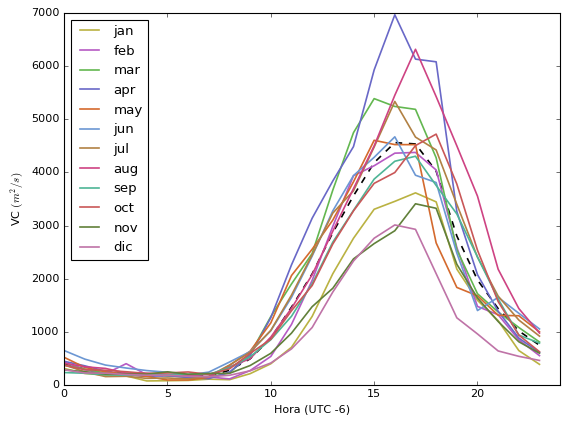

In [30]:
plt.figure(figsize=(8,6))
plt.plot(cca_vc_prom_hora.vc_mean.values, '--k', linewidth = '1.5')
colores=["#bab242",
"#b65ac4",
"#63b750",
"#6968c7",
"#d46a2e",
"#6c97d3",
"#b18144",
"#ce4383",
"#4eb596",
"#c95758",
"#61803a",
"#bf73a7"]
for i in range(1,13):
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    
    plt.plot(cca_vc[fecha_i:fecha_f].mean(), label = months[i], c = colores[i-1], linewidth = 1.5)

#plt.plot([0,24], [1,1], '--k')
#plt.ylim(-1,1)
plt.xlim(0,24)
plt.xlabel('Hora (UTC -6)')
plt.ylabel('VC $(m^2/s)$')
plt.legend(loc = 'upper left')

------------

In [31]:
cca_vc.mean(axis=1)['2015-01-01':'2015-01-31'].mean()

1193.8627450980391

In [32]:
cca_vc['2015-01-01':'2015-01-31'].values.mean()

1193.8627450980391

In [33]:
vc_max_mes = np.zeros(12)
vc_mean_mes = np.zeros(12)
meses_nom = []
for i in range(1,13):
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    vc_max_mes[i-1] = cca_vc.max(axis=1)[fecha_i:fecha_f].mean()
    vc_mean_mes[i-1] = cca_vc[fecha_i:fecha_f].values.mean()
    meses_nom.append(str.upper(months[i]))

In [34]:
meses_nom

['JAN',
 'FEB',
 'MAR',
 'APR',
 'MAY',
 'JUN',
 'JUL',
 'AUG',
 'SEP',
 'OCT',
 'NOV',
 'DIC']

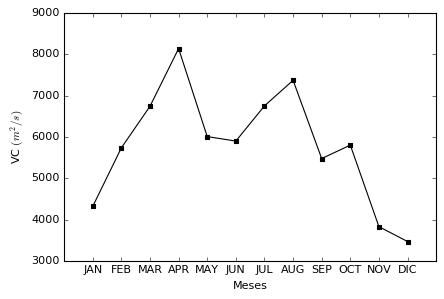

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(np.linspace(1,12, 12), vc_max_mes, marker='s', c = 'k')
ax.plot(np.linspace(1,12, 12), vc_max_mes, c = 'k')
ax.set_xlim(0,13)
#ax.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='^')
#ax.plot(np.linspace(1,12, 12), vc_mean_mes)
ax.set_xticks(range(1,13));
ax.set_xticklabels(meses_nom)
#ax.ticklabel_format
ax.set_xlabel('Meses')
ax.set_ylabel('VC $(m^2/s)$')

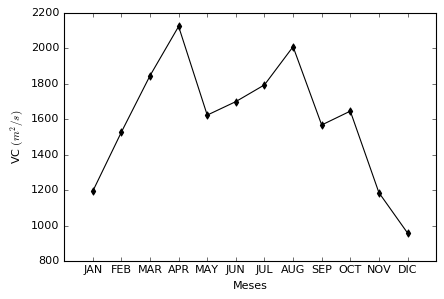

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.scatter(np.linspace(1,12, 12), vc_max_mes, marker='s', c = 'k')
#ax.plot(np.linspace(1,12, 12), vc_max_mes, c = 'k')
ax.set_xlim(0,13)
ax.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
ax.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')
ax.set_xticks(range(1,13));
ax.set_xticklabels(meses_nom)
#ax.ticklabel_format
ax.set_xlabel('Meses')
ax.set_ylabel('VC $(m^2/s)$')

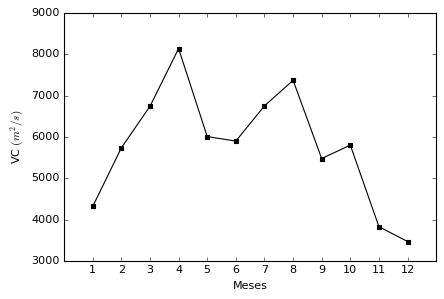

In [37]:
plt.scatter(np.linspace(1,12, 12), vc_max_mes, marker='s', c = 'k')
plt.plot(np.linspace(1,12, 12), vc_max_mes, c = 'k')
plt.xlim(0,13)
#plt.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='^')
#plt.plot(np.linspace(1,12, 12), vc_mean_mes)
plt.xticks(range(1,13));
#plt.ticklabel_format
plt.xlabel('Meses')
plt.ylabel('VC $(m^2/s)$')


In [38]:
cca_vc.max(axis=1)['2015-01-01':'2015-01-31'].mean()

4322.2352941176468

### $O_3$

In [40]:
o3_2015 = pd.read_csv("../datos/contaminantes/cca/O3_CCA_fixed.csv", index_col=0)

In [41]:
o3_2015.index = pd.to_datetime(o3_2015.index)

In [42]:
pd.date_range('2015-01-01', '2015-12-21', freq='1H').shape

(8497,)

In [43]:
o3_max_mes = np.zeros(12)
o3_mean_mes = np.zeros(12)

for i in range(1,13):
    
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    dd_num = np.int(dd)
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    #o3_max_mes[i-1] = o3_2015[fecha_i:fecha_f]
    o3_mean_mes[i-1] = o3_2015[fecha_i:fecha_f].mean()
    
    max_month = np.zeros(dd_num)
    for d in range(1, dd_num):
        max_month[d-1] = o3_2015[o3_2015.index.day==1][fecha_i:fecha_f].max().values
        
    o3_max_mes[i-1] = max_month.mean()

In [44]:
o3_max_mes

array([ 72.58064516,  44.35714286,  81.29032258,  84.1       ,
        78.38709677,  68.63333333,  68.70967742,  81.29032258,
        79.26666667,  48.38709677,  64.76666667,  82.25806452])

In [45]:
dd_num

31

In [46]:
o3_mean_mes

array([ 22.02269504,  23.03645008,  22.41997063,  31.        ,
        27.38888889,  25.06334842,  26.02513966,  27.56410256,
        23.01519757,  20.65356623,  18.52967359,  20.37048193])

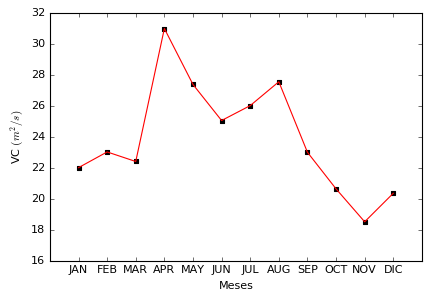

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(np.linspace(1,12, 12), o3_mean_mes, marker='s', c = 'k')
ax.plot(np.linspace(1,12, 12), o3_mean_mes, c = 'r')
ax.set_xlim(0,13)
#ax.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
#ax.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')
ax.set_xticks(range(1,13));
ax.set_xticklabels(meses_nom)
#ax.ticklabel_format
ax.set_xlabel('Meses')
ax.set_ylabel('VC $(m^2/s)$')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


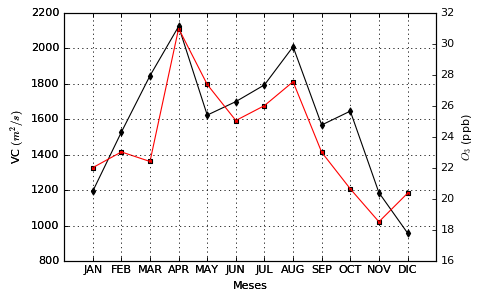

In [48]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_mean_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_mean_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


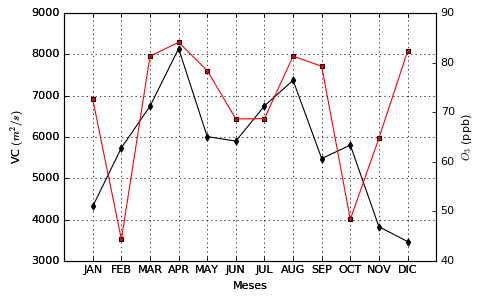

In [49]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_max_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_max_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


#### PM 2.5

In [50]:
pm25_2015 = pd.read_csv("../datos/contaminantes/cca/PM25_CCA_fixed.csv", index_col=0)
pm25_2015.index = pd.date_range('2015-01-01 01:00:00', '2016-01-01 00:00:00', freq='1H')

In [51]:
pm25_max_mes = np.zeros(12)
pm25_mean_mes = np.zeros(12)

for i in range(1,13):
    
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    dd_num = np.int(dd)
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    #pm25_max_mes[i-1] = pm25_2015[fecha_i:fecha_f]
    pm25_mean_mes[i-1] = pm25_2015[fecha_i:fecha_f].mean()
    
    max_month = np.zeros(dd_num)
    for d in range(1, dd_num):
        max_month[d-1] = pm25_2015[pm25_2015.index.day==1][fecha_i:fecha_f].max().values
        
    pm25_max_mes[i-1] = max_month.mean()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


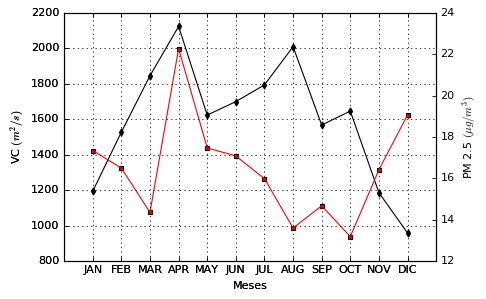

In [55]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("PM 2.5 $(\mu g/m^3)$")

host.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), pm25_mean_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), pm25_mean_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


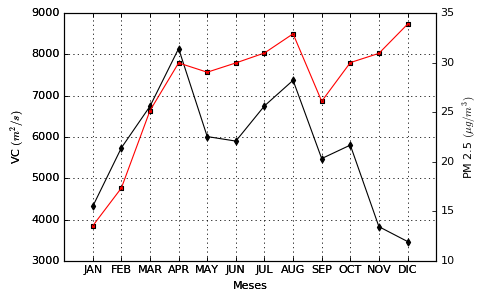

In [56]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("PM 2.5 $(\mu g/m^3)$")

host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_max_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), pm25_max_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), pm25_max_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


# SFE

In [97]:
sfe_vc = pd.read_csv("../datos/promedios_estaciones/SFE/VC_anual.csv", index_col= 0)

In [98]:
o3_2015_sfe = pd.read_csv("../datos/contaminantes/2015/SFE_o3_2015_noCol.csv", index_col=0, names=['no','station','cont', 'unit', 'conc'])

In [99]:
o3_2015_sfe.index = pd.to_datetime(o3_2015_sfe.index)

In [100]:
vc_max_mes = np.zeros(12)
vc_mean_mes = np.zeros(12)
meses_nom = []
for i in range(1,13):
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    vc_max_mes[i-1] = sfe_vc.max(axis=1)[fecha_i:fecha_f].mean()
    vc_mean_mes[i-1] = sfe_vc[fecha_i:fecha_f].values.mean()
    meses_nom.append(str.upper(months[i]))

In [101]:
o3_max_mes = np.zeros(12)
o3_mean_mes = np.zeros(12)

for i in range(1,13):
    
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    dd_num = np.int(dd)
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    #o3_max_mes[i-1] = o3_2015_sfe[fecha_i:fecha_f]
    o3_mean_mes[i-1] = o3_2015_sfe[fecha_i:fecha_f]['conc'].mean()
    
    max_month = np.zeros(dd_num)
    for d in range(1, dd_num):
        max_month[d-1] = o3_2015_sfe[o3_2015_sfe.index.day==1][fecha_i:fecha_f]['conc'].max()
        
    o3_max_mes[i-1] = max_month.mean()

In [102]:
o3_mean_mes

array([ 30.70873786,  29.38778626,  30.21693908,  43.79859155,
        38.18820225,  31.53521127,  35.61538462,  36.71134021,
                nan,          nan,          nan,          nan])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


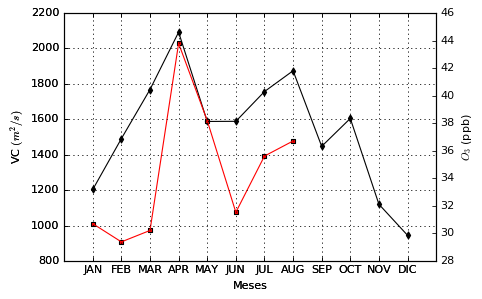

In [103]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_mean_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_mean_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


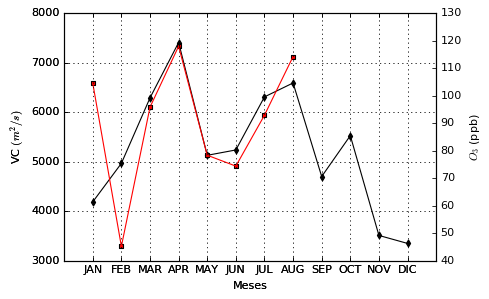

In [104]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_max_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_max_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


# CUA

In [105]:
cua_vc = pd.read_csv("../datos/promedios_estaciones/CUA/VC_anual.csv", index_col= 0)

In [106]:
o3_2015_cua = pd.read_csv("../datos/contaminantes/2015/CUA_o3_2015_noCol.csv", index_col=0, names=['no','station','cont', 'unit', 'conc'])

In [107]:
o3_2015_cua.index = pd.to_datetime(o3_2015_cua.index)

In [108]:
vc_max_mes = np.zeros(12)
vc_mean_mes = np.zeros(12)
meses_nom = []
for i in range(1,13):
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    vc_max_mes[i-1] = cua_vc.max(axis=1)[fecha_i:fecha_f].mean()
    vc_mean_mes[i-1] = cua_vc[fecha_i:fecha_f].values.mean()
    meses_nom.append(str.upper(months[i]))

In [109]:
o3_max_mes = np.zeros(12)
o3_mean_mes = np.zeros(12)

for i in range(1,13):
    
    fecha_i = '2015-' + '%02d'%i + '-01'
    dd = blt.E1or30(months[i])
    dd_num = np.int(dd)
    fecha_f = '2015-' + '%02d'%i + '-' + dd
    #print(fecha_f)
    #o3_max_mes[i-1] = o3_2015_cua[fecha_i:fecha_f]
    o3_mean_mes[i-1] = o3_2015_cua[fecha_i:fecha_f]['conc'].mean()
    
    max_month = np.zeros(dd_num)
    for d in range(1, dd_num):
        max_month[d-1] = o3_2015_cua[o3_2015_cua.index.day==1][fecha_i:fecha_f]['conc'].max()
        
    o3_max_mes[i-1] = max_month.mean()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


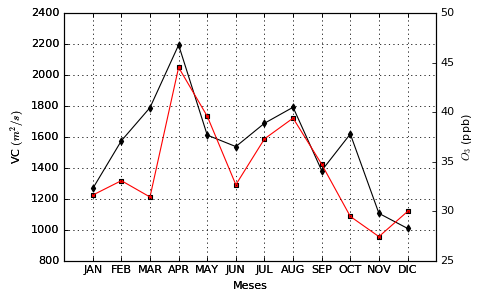

In [110]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_mean_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_mean_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_mean_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_mean_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


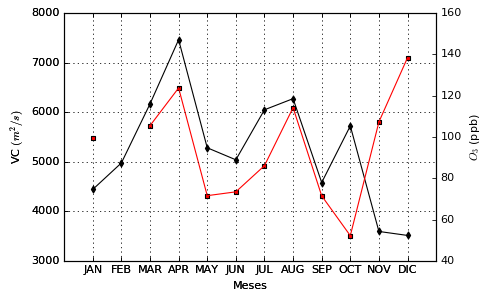

In [111]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust()

par1 = host.twinx()

offset = 60
#new_fixed_axis = par2.get_grid_helper().new_fixed_axis

host.set_xlim(0, 13)
#host.set_ylim(0, 2)

host.set_xlabel("Meses")
host.set_ylabel("VC $(m^2/s)$")
par1.set_ylabel("$O_3$ (ppb)")

host.scatter(np.linspace(1,12, 12), vc_max_mes, marker='d', c = 'k')
host.plot(np.linspace(1,12, 12), vc_max_mes,  c = 'k')

par1.scatter(np.linspace(1,12, 12), o3_max_mes, marker='s', c = 'r')
par1.plot(np.linspace(1,12, 12), o3_max_mes, c = 'r')
#par1.set_ylim(0, 4)

host.legend()
host.grid()

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
host.set_xticks(range(1,13));
host.set_xticklabels(meses_nom);
